<a href="https://colab.research.google.com/github/mtjon/infompr-group-project/blob/all_in_one/all_in_one-Damion_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For this notebook elemets were taken from:
1. https://www.tensorflow.org/text/tutorials/nmt_with_attention, and;
2. https://www.tensorflow.org/text/tutorials/transformer

For the RNN + GRU, bi-directional layer was removed. For the transformer, all sub-classing has been copied, as well as custom learning schedule.

Data-preprocessing has been adopted to fit the dataset used, which can be found here:
- Data loading: https://github.com/EagleW/Writing-editing-Network/blob/master/split_data.py
- Dataset: https://github.com/EagleW/ACL_titles_abstracts_dataset

We've manually adjusted the dataset to remove the empty rows between title-abstract pairs, and adjusted the data loading code to work with the changes accordingly.

# Installing and loading Required packages

In [1]:
# Install the most re version of TensorFlow to use the improved
# masking support for `tf.keras.layers.MultiHeadAttention`.
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text==2.11.* tensorflow==2.11.*
!pip install einops

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libcudnn8 is already the newest version (8.1.0.77-1+cuda11.2).
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 72.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 75.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import logging
import time

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text
import tensorflow_text as tf_text

# For data loading and shuffling
import random
from random import shuffle

# for shape checking -> used in RNN and GRU, see class below
import einops

In [3]:
#@title
class ShapeChecker():
  def __init__(self):
    # Keep a cache of every axis-name seen
    self.shapes = {}

  def __call__(self, tensor, names, broadcast=False):
    if not tf.executing_eagerly():
      return

    parsed = einops.parse_shape(tensor, names)

    for name, new_dim in parsed.items():
      old_dim = self.shapes.get(name, None)
      
      if (broadcast and new_dim == 1):
        continue

      if old_dim is None:
        # If the axis name is new, add its length to the cache.
        self.shapes[name] = new_dim
        continue

      if new_dim != old_dim:
        raise ValueError(f"Shape mismatch for dimension: '{name}'\n"
                         f"    found: {new_dim}\n"
                         f"    expected: {old_dim}\n")

# Data Loading

## Functions

In [4]:
# modified data externally to remove all blank lines
random.seed(42)
def write_data(f, ext, mod):
    # Code van https://github.com/EagleW/Writing-editing-Network/blob/master/split_data.py
    file1=open(f, 'r')
    lines=file1.readlines()
    print(len(lines))
    file1.close()
    abs_t = []
    abstracts = []
    titles = []
    i = 0
    # TODO: possibly generates wrong tibs/abs when encounter
    for line in lines:
        if i % mod == 0:
            titles.append(line)
        elif i % mod == 1:
            abstracts.append(line)
        i += 1
    for i in range(len(abstracts)):
        if len(titles[i]) > 0 and len(abstracts[i]) > 0:
            h_a_pair = (titles[i], abstracts[i])
            abs_t.append(h_a_pair)
    shuffle(abs_t)
    total = len(abs_t)
    dev = total//10
    train  = total - dev - dev
    i = 0
    file1=open("val{}.txt".format(ext), 'w')
    for i in range(dev):
        file1.writelines(abs_t[i][0])
        file1.writelines(abs_t[i][1])
    #    file1.writelines("\n")
    file1.close()
    file1=open("test{}.txt".format(ext), 'w')
    for i in range(dev, 2 * dev):
        file1.writelines(abs_t[i][0])
        file1.writelines(abs_t[i][1])
    #    file1.writelines("\n")
    file1.close()
    file1=open("train{}.txt".format(ext), 'w')
    for i in range(2 * dev, total):
        file1.writelines(abs_t[i][0])
        file1.writelines(abs_t[i][1])
    #    file1.writelines("\n")
    file1.close()

def get_abs_and_titles_from_raw(path_to_file):
    abstracts, titles = [], []
    abscount, titcount = 0, 0
    with open(path_to_file) as data:
        lines = data.readlines()
        print(len(lines))
        for abs in lines[1::2]:
            abstracts.append(abs.strip())
            abscount += 1
        for title in lines[0::2]:
            # // TODO: check if we need to add start and end tokens
            titles.append(title.strip())
            titcount+=1
            # titles.append('[START] ' + title.strip() + ' [END]')
    print(abscount, titcount)
    # print(titles[-1],'\n',titles[-2])
    return abstracts, titles

## Loading data

Make sure to have the modified dataset uploaden (i.e., ACL title+abs data set with empty rows removed).

### Writing and loading text files

In [5]:
write_data("acl_titles_and_abstracts_mod.txt", "", 2) # writes train, val, test.txt

21750


In [6]:
train_text, train_labels = get_abs_and_titles_from_raw('train.txt')
val_text, val_labels = get_abs_and_titles_from_raw('val.txt')
test_text, test_labels = get_abs_and_titles_from_raw('test.txt')

17402
8701 8701
2174
1087 1087
2174
1087 1087


### Sanity checks

In [7]:
print(train_labels[0])
print(train_text[0])

heideltime : tuning english and developing spanish resources
in this paper , we describe our participation in the tempeval-3 challenge . with our multilingual temporal tagger heideltime , we addressed task a , the extraction and normalization of temporal expressions for english and spanish . exploiting heideltimes strict separation between source code and languagedependent parts , we tuned heideltimes existing english resources and developed new spanish resources . for both languages , we achieved the best results among all participants for task a , the combination of extraction and normalization . both the improved english and the new spanish resources are publicly available with heideltime .


In [8]:
print(val_labels[0])
print(val_text[0])

computational analysis to explore authors depiction of characters cecilia ovesdotter alm
this study involves automatically identifying the sociolinguistic characteristics of fictional characters in plays by analyzing their written speech . we discuss three binary classification problems : predicting the characters gender ( male vs. female ) , age ( young vs. old ) , and socioeconomic standing ( upper-middle class vs. lower class ) . the text corpus used is an annotated collection of august strindberg and henrik ibsen plays , translated into english , which are in the public domain . these playwrights were chosen for their known attention to relevant socioeconomic issues in their work . linguistic and textual cues are extracted from the characters lines ( turns ) for modeling purposes . we report on the dataset as well as the performance and important features when predicting each of the sociolinguistic characteristics , comparing intra- and inter-author testing .


In [9]:
print(test_labels[0])
print(test_text[0])

recognizing named entities in tweets
the challenges of named entities recognition ( ner ) for tweets lie in the insufficient information in a tweet and the unavailability of training data . we propose to combine a k-nearest neighbors ( knn ) classifier with a linear conditional random fields ( crf ) model under a semi-supervised learning framework to tackle these challenges . the knn based classifier conducts pre-labeling to collect global coarse evidence across tweets while the crf model conducts sequential labeling to capture fine-grained information encoded in a tweet . the semi-supervised learning plus the gazetteers alleviate the lack of training data . extensive experiments show the advantages of our method over the baselines as well as the effectiveness of knn and semisupervised learning .


### Batching

In [10]:
BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices((train_text, train_labels)).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((val_text, val_labels)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((test_text, test_labels)).batch(BATCH_SIZE)

In [11]:
counter = 0
for abs, tit in train_dataset.take(1):
    print('> Abstract examples:')
    for i, a in enumerate(abs.numpy()):
        print(i+1, a.decode('utf-8'))
        
    print()
    
    print('> Title examples:')
    for i, t in enumerate(tit.numpy()):
        print(i+1, t.decode('utf-8'))
    
    counter += 1
    if counter == 10:
        break

> Abstract examples:
1 in this paper , we describe our participation in the tempeval-3 challenge . with our multilingual temporal tagger heideltime , we addressed task a , the extraction and normalization of temporal expressions for english and spanish . exploiting heideltimes strict separation between source code and languagedependent parts , we tuned heideltimes existing english resources and developed new spanish resources . for both languages , we achieved the best results among all participants for task a , the combination of extraction and normalization . both the improved english and the new spanish resources are publicly available with heideltime .
2 we present three novel methods of compactly storing very large n-gram language models . these methods use substantially less space than all known approaches and allow n-gram probabilities or counts to be retrieved in constant time , at speeds comparable to modern language modeling toolkits . our basic approach generates an explicit

# Preprocessing

In [12]:
def title_preprocessor(text):
    text = tf.strings.lower(text)
    text = tf.strings.strip(text)
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

def abstract_preprocessor(text):
    text = tf.strings.lower(text)
    text = tf.strings.strip(text)
    # Added start and end tokens. read somewhere its important for the RNNs
    # not for transformer.. Idk.
    # - Damion
    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text

# def abstract_preprocessor_mk2(text):
#     # from: https://www.tensorflow.org/text/tutorials/nmt_with_attention#text_preprocessing
#     # I've included this below code for preprocessing, since in the abstract,
#     # punctuation etc isnt important - perhaps. Only for the titles. 
#     # So, perhaps performance increase
#     # - Damion

#     # Additionally, the start and end token seem to do something
#     # for the RNN's?
#     # Split accente d characters.
    
#     #text = tf_text.normalize_utf8(text, 'NFKD')
#     #text = tf.strings.lower(text)
    
#     # Keep space, a to z, and select punctuation.
#     #text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
#     text = tf.strings.regex_replace(text, '[^ a-z]', '')
    
#     # Add spaces around punctuation.
#     #text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
    
#     # Strip whitespace.
#     text = tf.strings.strip(text)

#     text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
#     return text

abs_text_processor = tf.keras.layers.TextVectorization(
    standardize=abstract_preprocessor,
    ragged=True,
    output_mode='int'
    )

# abs_text_processor = tf.keras.layers.TextVectorization(
#     standardize=abstract_preprocessor_mk2,
#     ragged=True,
#     output_mode='int'
#     )

tit_text_processor = tf.keras.layers.TextVectorization(
    standardize=title_preprocessor,
    ragged=True,
    output_mode='int'
    )

abs_text_processor.adapt(train_dataset.map(lambda abs, tit: abs))
tit_text_processor.adapt(train_dataset.map(lambda abs, tit: tit))

def process_text(context, target):
    context = abs_text_processor(context).to_tensor()
    target = tit_text_processor(target)
    targ_in = target[:,:-1].to_tensor()
    targ_out = target[:,1:].to_tensor()
    return (context, targ_in), targ_out


train_ds = train_dataset.map(process_text, tf.data.AUTOTUNE)
val_ds = val_dataset.map(process_text, tf.data.AUTOTUNE)
test_ds = test_dataset.map(process_text, tf.data.AUTOTUNE)



Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [13]:
for (ex_context_tok, ex_tar_in), ex_tar_out in train_ds.take(1):
    print(ex_context_tok[0, :10].numpy()) 
    print()
    print(ex_tar_in[0, :10].numpy()) 
    print(ex_tar_out[0, :10].numpy())

[  16    9   15   27    4   10  112   24 1296    9]

[   2 2793    9  740   95    6  454  529  150    0]
[2793    9  740   95    6  454  529  150    3    0]


# Models + components

## RNN + GRU components

In [14]:
class EncoderRNN(tf.keras.layers.Layer):
  def __init__(self, text_processor, units, GRU=False):
    super(EncoderRNN, self).__init__()
    self.text_processor = text_processor
    self.vocab_size = text_processor.vocabulary_size()
    self.units = units

    # The embedding layer converts tokens to vectors
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, units,
                                               mask_zero=True)

    # The RNN layer processes those vectors sequentially.
    # self.rnn = tf.keras.layers.Bidirectional(
    #     merge_mode='sum',
    #     layer=tf.keras.layers.GRU(units,
    #                         # Return the sequence and state
    #                         return_sequences=True,
    #                         recurrent_initializer='glorot_uniform'))
    if not GRU:
        self.rnn = (tf.keras.layers \
                    .SimpleRNN(units,
                    # Return the sequence and state
                    return_sequences=True,
                    recurrent_initializer='glorot_uniform'))
    else:
        self.rnn = (tf.keras.layers
                    .GRU(units,
                    # Return the sequence and state
                    return_sequences=True,
                    recurrent_initializer='glorot_uniform'))

  def call(self, x):
    shape_checker = ShapeChecker()
    shape_checker(x, 'batch s')

    # 2. The embedding layer looks up the embedding vector for each token.
    x = self.embedding(x)
    shape_checker(x, 'batch s units')

    # 3. The GRU processes the sequence of embeddings.
    x = self.rnn(x)
    shape_checker(x, 'batch s units')

    # 4. Returns the new sequence of embeddings.
    return x

  def convert_input(self, texts):
    texts = tf.convert_to_tensor(texts)
    if len(texts.shape) == 0:
      texts = tf.convert_to_tensor(texts)[tf.newaxis]
    context = self.text_processor(texts).to_tensor()
    context = self(context)
    return context

In [15]:
class CrossAttentionRNN(tf.keras.layers.Layer):
  def __init__(self, units, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
    self.layernorm = tf.keras.layers.LayerNormalization()
    self.add = tf.keras.layers.Add()

  def call(self, x, context):
    shape_checker = ShapeChecker()

    shape_checker(x, 'batch t units')
    shape_checker(context, 'batch s units')

    attn_output, attn_scores = self.mha(
        query=x,
        value=context,
        return_attention_scores=True)

    shape_checker(x, 'batch t units')
    shape_checker(attn_scores, 'batch heads t s')

    # Cache the attention scores for plotting later.
    attn_scores = tf.reduce_mean(attn_scores, axis=1)
    shape_checker(attn_scores, 'batch t s')
    self.last_attention_weights = attn_scores

    x = self.add([x, attn_output])
    x = self.layernorm(x)

    return x

In [16]:
class DecoderRNN(tf.keras.layers.Layer):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, text_processor, units, GRU=True):
        super(DecoderRNN, self).__init__()
        self.text_processor = text_processor
        self.vocab_size = text_processor.vocabulary_size()
        self.word_to_id = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', oov_token='[UNK]')
        self.id_to_word = tf.keras.layers.StringLookup(
            vocabulary=text_processor.get_vocabulary(),
            mask_token='', oov_token='[UNK]',
            invert=True)
        self.start_token = self.word_to_id('[START]')
        self.end_token = self.word_to_id('[END]')
        print('Did start- and end-token get stored properly?')
        print(self.start_token, self.end_token)

        self.units = units


        # 1. The embedding layer converts token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(self.vocab_size,
                                                    units, mask_zero=True)

        # 2. The RNN keeps track of what's been generated so far.
        if not GRU:
            self.rnn = (tf.keras.layers \
                        .SimpleRNN(units,
                        # Return the sequence and state
                        return_sequences=True,
                        return_state=True,
                        recurrent_initializer='glorot_uniform'))
        else:
            self.rnn = (tf.keras.layers \
                        .GRU(units,
                        # Return the sequence and state
                        return_sequences=True,
                        return_state=True,
                        recurrent_initializer='glorot_uniform'))

        # 3. The RNN output will be the query for the attention layer.
        self.attention = CrossAttentionRNN(units)

        # 4. This fully connected layer produces the logits for each
        # output token.
        self.output_layer = tf.keras.layers.Dense(self.vocab_size)

    def call(self,
            context, x,
            state=None,
            return_state=False):  
        shape_checker = ShapeChecker()
        shape_checker(x, 'batch t')
        shape_checker(context, 'batch s units')

        # 1. Lookup the embeddings
        x = self.embedding(x)
        shape_checker(x, 'batch t units')

        # 2. Process the target sequence.
        x, state = self.rnn(x, initial_state=state)
        shape_checker(x, 'batch t units')

        # 3. Use the RNN output as the query for the attention over the context.
        x = self.attention(x, context)
        self.last_attention_weights = self.attention.last_attention_weights
        shape_checker(x, 'batch t units')
        shape_checker(self.last_attention_weights, 'batch t s')

        # Step 4. Generate logit predictions for the next token.
        logits = self.output_layer(x)
        shape_checker(logits, 'batch t target_vocab_size')

        if return_state:
            return logits, state
        else:
            return logits

    def get_initial_state(self, context):
        batch_size = tf.shape(context)[0]
        start_tokens = tf.fill([batch_size, 1], self.start_token)
        done = tf.zeros([batch_size, 1], dtype=tf.bool)
        embedded = self.embedding(start_tokens)
        return start_tokens, done, self.rnn.get_initial_state(embedded)[0]
    
    def tokens_to_text(self, tokens):
        words = self.id_to_word(tokens)
        result = tf.strings.reduce_join(words, axis=-1, separator=' ')
        result = tf.strings.regex_replace(result, '^ *\[START\] *', '')
        result = tf.strings.regex_replace(result, ' *\[END\] *$', '')
        return result

    def get_next_token(self, context, next_token, done, state, temperature = 0.0):
        logits, state = self(
        context, next_token,
        state = state,
        return_state=True) 

        if temperature == 0.0:
            next_token = tf.argmax(logits, axis=-1)
        else:
            logits = logits[:, -1, :]/temperature
            next_token = tf.random.categorical(logits, num_samples=1)

        # If a sequence produces an `end_token`, set it `done`
        done = done | (next_token == self.end_token)
        # Once a sequence is done it only produces 0-padding.
        next_token = tf.where(done, tf.constant(0, dtype=tf.int64), next_token)

        return next_token, done, state

In [17]:
class Translator(tf.keras.Model):
    @classmethod
    def add_method(cls, fun):
        setattr(cls, fun.__name__, fun)
        return fun

    def __init__(self, units,
                context_text_processor,
                target_text_processor,
                GRU=True):
        super().__init__()
        # Build the encoder and decoder
        # GRU False will result in SimpleRNN instead of GRU
        self.encoder = EncoderRNN(context_text_processor, units, GRU=GRU)
        self.decoder = DecoderRNN(target_text_processor, units, GRU=GRU)

    def call(self, inputs):
        context, x = inputs
        context = self.encoder(context)
        logits = self.decoder(context, x)

        #TODO(b/250038731): remove this
        try:
            # Delete the keras mask, so keras doesn't scale the loss+accuracy. 
            del logits._keras_mask
        except AttributeError:
            pass

        return logits
    
    def translate(self,
                texts, *,
                max_length=50,
                temperature=0.0):
        # Process the input texts
        context = self.encoder.convert_input(texts)
        batch_size = tf.shape(texts)[0]

        # Setup the loop inputs
        tokens = []
        attention_weights = []
        next_token, done, state = self.decoder.get_initial_state(context)

        for _ in range(max_length):
            # Generate the next token
            next_token, done, state = self.decoder.get_next_token(
                context, next_token, done,  state, temperature)

            # Collect the generated tokens
            tokens.append(next_token)
            attention_weights.append(self.decoder.last_attention_weights)

            if tf.executing_eagerly() and tf.reduce_all(done):
                break

        # Stack the lists of tokens and attention weights.
        tokens = tf.concat(tokens, axis=-1)   # t*[(batch 1)] -> (batch, t)
        self.last_attention_weights = tf.concat(attention_weights, axis=1)  # t*[(batch 1 s)] -> (batch, t s)

        result = self.decoder.tokens_to_text(tokens)
        return result

## Transformer Component

In [18]:
class PositionalEmbeddingT(tf.keras.layers.Layer):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
        self.pos_encoding = self.positional_encoding(length=2048, depth=d_model)
    
    def compute_mask(self, *args, **kwargs):
        return self.embedding.compute_mask(*args, **kwargs)
    
    def call(self, x):
        length = tf.shape(x)[1]
        x = self.embedding(x)
        # This factor sets the relative scale of the embedding and positonal_encoding.
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x = x + self.pos_encoding[tf.newaxis, :length, :]
        return x
    
    def positional_encoding(self, length, depth):
        depth = depth/2

        positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
        depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

        angle_rates = 1 / (10000**depths)         # (1, depth)
        angle_rads = positions * angle_rates      # (pos, depth)

        pos_encoding = np.concatenate(
            [np.sin(angle_rads), np.cos(angle_rads)],
            axis=-1) 

        return tf.cast(pos_encoding, dtype=tf.float32)

class BaseAttentionT(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

class CrossAttentionT(BaseAttentionT):
    def call(self, x, context):
        attn_output, attn_scores = self.mha(
            query=x,
            key=context,
            value=context,
            return_attention_scores=True)
        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class GlobalSelfAttentionT(BaseAttentionT):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class CausalSelfAttentionT(BaseAttentionT):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x,
            use_causal_mask = True)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class FeedForwardT(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model),
            tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()
    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x

In [19]:
class EncoderLayerT(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
        super().__init__()

        self.self_attention = GlobalSelfAttentionT(
            num_heads=num_heads,
            key_dim=d_model,
            dropout=dropout_rate)

        self.ffn = FeedForwardT(d_model, dff)

    def call(self, x):
        x = self.self_attention(x)
        x = self.ffn(x)
        return x

class EncoderT(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads,
                dff, vocab_size, dropout_rate=0.1):
        super().__init__()

        # Wanneer we translator maken moeten we het volgende gebruiken:
        # self.text_processor = text_processor
        # self.vocab_size = vocab_size

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbeddingT(
            vocab_size=vocab_size, d_model=d_model)

        self.enc_layers = [
            EncoderLayerT(d_model=d_model,
                            num_heads=num_heads,
                            dff=dff,
                            dropout_rate=dropout_rate)
            for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(dropout_rate)

    def call(self, x):
        # `x` is token-IDs shape: (batch, seq_len)
        x = self.pos_embedding(x)  # Shape `(batch_size, seq_len, d_model)`.

        # Add dropout.
        x = self.dropout(x)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # Shape `(batch_size, seq_len, d_model)`.

    def convert_input(self, texts):
        pass

In [20]:
class DecoderLayerT(tf.keras.layers.Layer):
  def __init__(self,
               *,
               d_model,
               num_heads,
               dff,
               dropout_rate=0.1):
    super(DecoderLayerT, self).__init__()

    self.causal_self_attention = CausalSelfAttentionT(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)
    
    self.cross_attention = CrossAttentionT(
        num_heads=num_heads,
        key_dim=d_model,
        dropout=dropout_rate)

    self.ffn = FeedForwardT(d_model, dff)

  def call(self, x, context):
    x = self.causal_self_attention(x=x)
    x = self.cross_attention(x=x, context=context)

    # Cache the last attention scores for plotting later
    self.last_attn_scores = self.cross_attention.last_attn_scores

    x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
    return x

class DecoderT(tf.keras.layers.Layer):
    def __init__(self, *, num_layers, d_model, num_heads, dff, vocab_size,
                dropout_rate=0.1):
        super(DecoderT, self).__init__()
        ### TODO:
        # word_to_id etc, zie RNN decoder van Nick en Jan

        self.d_model = d_model
        self.num_layers = num_layers

        self.pos_embedding = PositionalEmbeddingT(vocab_size=vocab_size,
                                                    d_model=d_model)
        self.dropout = tf.keras.layers.Dropout(dropout_rate)
        self.dec_layers = [
            DecoderLayerT(d_model=d_model, num_heads=num_heads,
                            dff=dff, dropout_rate=dropout_rate)
            for _ in range(num_layers)]

        self.last_attn_scores = None

    def call(self, x, context):
        # `x` is token-IDs shape (batch, target_seq_len)
        x = self.pos_embedding(x)  # (batch_size, target_seq_len, d_model)

        x = self.dropout(x)

        for i in range(self.num_layers):
            x  = self.dec_layers[i](x, context)

        self.last_attn_scores = self.dec_layers[-1].last_attn_scores

        # The shape of x is (batch_size, target_seq_len, d_model).
        return x

In [21]:
class Transformer(tf.keras.Model):
    def __init__(self, *, num_layers, d_model, num_heads, dff,
                input_vocab_size, target_vocab_size, dropout_rate=0.1):
        super().__init__()
        self.encoder = EncoderT(num_layers=num_layers, d_model=d_model,
                                num_heads=num_heads, dff=dff,
                                vocab_size=input_vocab_size,
                                dropout_rate=dropout_rate)

        self.decoder = DecoderT(num_layers=num_layers, d_model=d_model,
                                num_heads=num_heads, dff=dff,
                                vocab_size=target_vocab_size,
                                dropout_rate=dropout_rate)

        self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
    def call(self, inputs):
        # To use a Keras model with `.fit` you must pass all your inputs in the
        # first argument.
        context, x = inputs

        context = self.encoder(context)  # (batch_size, context_len, d_model)

        x = self.decoder(x, context)  # (batch_size, target_len, d_model)

        # Final linear layer output.
        logits = self.final_layer(x)  # (batch_size, target_len, target_vocab_size)

        try:
            # Drop the keras mask, so it doesn't scale the losses/metrics.
            # b/250038731
            del logits._keras_mask
        except AttributeError:
            pass

        # Return the final output and the attention weights.
        return logits

# Training

## Training functions

In [22]:
def masked_loss(label, pred):
    mask = label != 0
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss


def masked_accuracy(label, pred):
    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    match = label == pred

    mask = label != 0

    match = match & mask

    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [23]:
# Used for transformer
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=tf.float32)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
  
  def get_config(self):
      config = {
      'd_model': self.d_model,
      'warmup_steps': self.warmup_steps,

        }
      return config

## Models setup (with hyper-pars)

In [24]:
# RNN
RNN_UNITS = 32
modelRNN = Translator(RNN_UNITS, abs_text_processor, tit_text_processor, GRU=False)


Did start- and end-token get stored properly?
tf.Tensor(2, shape=(), dtype=int64) tf.Tensor(3, shape=(), dtype=int64)


In [25]:
# GRU
GRU_UNITS = 32
modelGRU = Translator(GRU_UNITS, abs_text_processor, tit_text_processor, GRU=True)

Did start- and end-token get stored properly?
tf.Tensor(2, shape=(), dtype=int64) tf.Tensor(3, shape=(), dtype=int64)


In [26]:
# Transformer hyper pars
num_layers = 1
d_model = 16
dff = 32
num_heads = 1 # was 8
dropout_rate = 0.1

# Training pars
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

# Load model
modelT = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=len(abs_text_processor.get_vocabulary()),
    target_vocab_size=len(tit_text_processor.get_vocabulary()),
    dropout_rate=dropout_rate)

## Compile

In [27]:
modelGRU.compile(
    loss=masked_loss,
    optimizer='Adam',
    metrics=[masked_accuracy])

In [28]:
modelRNN.compile(
    loss=masked_loss,
    optimizer='Adam',
    metrics=[masked_accuracy])

In [29]:
modelT.compile(
    loss=masked_loss,
    optimizer=optimizer,
    metrics=[masked_accuracy])

## Training

### Train RNN

In [30]:
with tf.device('/device:GPU:0'):
    historyRNN = modelRNN.fit(train_ds,
                            epochs=30,
                            validation_data=val_ds,
                            callbacks=tf.keras.callbacks.EarlyStopping(
                                monitor='val_loss',
                                patience=3))

Epoch 1/30
136/136 [==============================] - 108s 728ms/step - loss: 7.5685 - masked_accuracy: 0.0506 - val_loss: 6.7872 - val_masked_accuracy: 0.0951
Epoch 2/30
136/136 [==============================] - 68s 497ms/step - loss: 6.5060 - masked_accuracy: 0.1085 - val_loss: 6.4865 - val_masked_accuracy: 0.1214
Epoch 3/30
136/136 [==============================] - 53s 390ms/step - loss: 6.0733 - masked_accuracy: 0.1410 - val_loss: 6.2185 - val_masked_accuracy: 0.1549
Epoch 4/30
136/136 [==============================] - 53s 388ms/step - loss: 5.6849 - masked_accuracy: 0.1774 - val_loss: 6.0577 - val_masked_accuracy: 0.1738
Epoch 5/30
136/136 [==============================] - 54s 393ms/step - loss: 5.3540 - masked_accuracy: 0.2110 - val_loss: 5.9715 - val_masked_accuracy: 0.1863
Epoch 6/30
136/136 [==============================] - 53s 388ms/step - loss: 5.0685 - masked_accuracy: 0.2401 - val_loss: 5.9406 - val_masked_accuracy: 0.1888
Epoch 7/30
136/136 [=========================

### Train GRU

In [31]:
with tf.device('/device:GPU:0'):
    historyGRU = modelGRU.fit(train_ds,
                            epochs=30,
                            validation_data=val_ds,
                            callbacks=tf.keras.callbacks.EarlyStopping(
                                monitor='val_loss',
                                patience=3))

Epoch 1/30
136/136 [==============================] - 37s 200ms/step - loss: 7.5511 - masked_accuracy: 0.0942 - val_loss: 6.8085 - val_masked_accuracy: 0.0951
Epoch 2/30
136/136 [==============================] - 8s 61ms/step - loss: 6.5778 - masked_accuracy: 0.1025 - val_loss: 6.5535 - val_masked_accuracy: 0.1201
Epoch 3/30
136/136 [==============================] - 8s 61ms/step - loss: 6.1419 - masked_accuracy: 0.1392 - val_loss: 6.2124 - val_masked_accuracy: 0.1519
Epoch 4/30
136/136 [==============================] - 8s 61ms/step - loss: 5.7337 - masked_accuracy: 0.1760 - val_loss: 6.0225 - val_masked_accuracy: 0.1810
Epoch 5/30
136/136 [==============================] - 8s 62ms/step - loss: 5.4070 - masked_accuracy: 0.2108 - val_loss: 5.9029 - val_masked_accuracy: 0.1916
Epoch 6/30
136/136 [==============================] - 8s 62ms/step - loss: 5.1252 - masked_accuracy: 0.2360 - val_loss: 5.8192 - val_masked_accuracy: 0.2005
Epoch 7/30
136/136 [==============================] - 8s

### Train Transformer

In [32]:
with tf.device('/device:GPU:0'):
    historyT = modelT.fit(train_ds,
                            epochs=30,
                            validation_data=val_ds,
                            callbacks=tf.keras.callbacks.EarlyStopping(
                                monitor='val_loss',
                                patience=3))

Epoch 1/30
136/136 [==============================] - 53s 314ms/step - loss: 9.2250 - masked_accuracy: 8.0066e-04 - val_loss: 9.1436 - val_masked_accuracy: 0.0040
Epoch 2/30
136/136 [==============================] - 4s 32ms/step - loss: 8.9524 - masked_accuracy: 0.0161 - val_loss: 8.7246 - val_masked_accuracy: 0.0284
Epoch 3/30
136/136 [==============================] - 5s 33ms/step - loss: 8.3556 - masked_accuracy: 0.0274 - val_loss: 8.0338 - val_masked_accuracy: 0.0281
Epoch 4/30
136/136 [==============================] - 4s 32ms/step - loss: 7.5400 - masked_accuracy: 0.0280 - val_loss: 7.2748 - val_masked_accuracy: 0.0281
Epoch 5/30
136/136 [==============================] - 4s 31ms/step - loss: 6.8666 - masked_accuracy: 0.0776 - val_loss: 6.9076 - val_masked_accuracy: 0.0951
Epoch 6/30
136/136 [==============================] - 5s 34ms/step - loss: 6.6124 - masked_accuracy: 0.0968 - val_loss: 6.7817 - val_masked_accuracy: 0.0951
Epoch 7/30
136/136 [==============================] 

## Training summary

In [33]:
def plot_history(history, model_name):
    # Acc's
    plt.plot(history.history['masked_accuracy'])
    plt.plot(history.history['val_masked_accuracy'])
    plt.title(f'model accuracy - {model_name}')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'model loss - {model_name}')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

### RNN

In [34]:
modelRNN.summary()

Model: "translator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_rnn (EncoderRNN)    multiple                  877184    
                                                                 
 decoder_rnn (DecoderRNN)    multiple                  691923    
                                                                 
Total params: 1,569,107
Trainable params: 1,569,107
Non-trainable params: 0
_________________________________________________________________


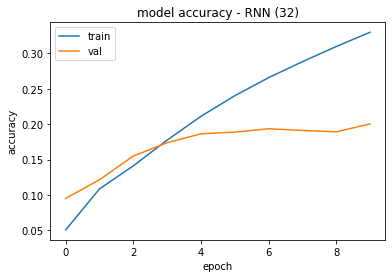

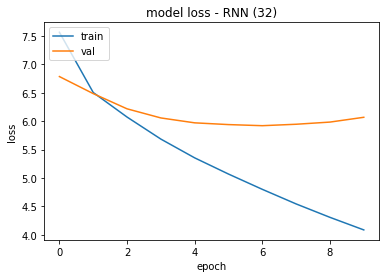

In [35]:
plot_history(historyRNN, f'RNN ({RNN_UNITS})')

### GRU

In [36]:
modelGRU.summary()

Model: "translator_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_rnn_1 (EncoderRNN)  multiple                  881440    
                                                                 
 decoder_rnn_1 (DecoderRNN)  multiple                  696179    
                                                                 
Total params: 1,577,619
Trainable params: 1,577,619
Non-trainable params: 0
_________________________________________________________________


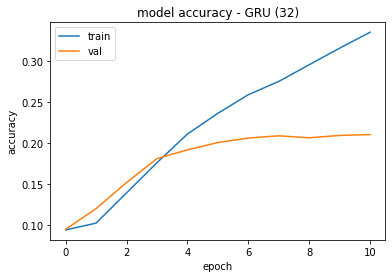

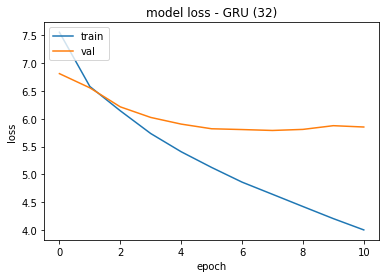

In [37]:
plot_history(historyGRU, f'GRU ({GRU_UNITS})')

### Transformer

In [38]:
modelT.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_t (EncoderT)        multiple                  439776    
                                                                 
 decoder_t (DecoderT)        multiple                  172096    
                                                                 
 dense_6 (Dense)             multiple                  179299    
                                                                 
Total params: 791,171
Trainable params: 791,171
Non-trainable params: 0
_________________________________________________________________


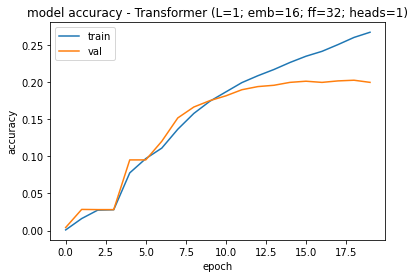

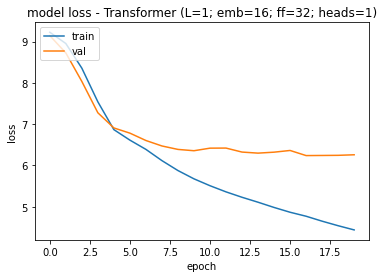

In [41]:
# for naming
pars = dict(L = num_layers, emb = d_model, ff = dff, heads = num_heads)

s = ''
for k, v in pars.items():
    s += f'{k}={v}; '
s = s[:-2]

# plot history
plot_history(historyT, f'Transformer ({s})')

# Inference

1. Add inference from both branches on git, as implemented. Adjust variable names with above.
2. Use same sample from test-set




In [62]:
def print_translation(abs, pred, ground_truth):
    print(f'{"Input:":15s}: {abs}')
    print(f'{"Prediction":15s}: {pred}')
    print(f'{"Ground truth":15s}: {ground_truth}')

samples = random.sample(range(1087), 6)
print(samples)
rnn_x1, rnn_y1 = test_text[samples[0]], test_labels[samples[0]]
rnn_x2, rnn_y2 = test_text[samples[1]], test_labels[samples[1]]
gru_x1, gru_y1 = test_text[samples[2]], test_labels[samples[2]]
gru_x2, gru_y2 = test_text[samples[3]], test_labels[samples[3]]
tr_x1, tr_y1 = test_text[samples[4]], test_labels[samples[4]]
tr_x2, tr_y2 = test_text[samples[5]], test_labels[samples[5]]

# y1 = 'recognizing named entities in tweets'
# x1 = 'the challenges of named entities recognition ( ner ) for tweets lie in the insufficient information in a tweet and the unavailability of training data . we propose to combine a k-nearest neighbors ( knn ) classifier with a linear conditional random fields ( crf ) model under a semi-supervised learning framework to tackle these challenges . the knn based classifier conducts pre-labeling to collect global coarse evidence across tweets while the crf model conducts sequential labeling to capture fine-grained information encoded in a tweet . the semi-supervised learning plus the gazetteers alleviate the lack of training data . extensive experiments show the advantages of our method over the baselines as well as the effectiveness of knn and semisupervised learning .'

# y2 = 'interactive grammar development with wcdg'
# x2 = 'the manual design of grammars for accurate natural language analysis is an iterative process ; while modelling decisions usually determine parser behaviour , evidence from analysing more or different input can suggest unforeseen regularities , which leads to a reformulation of rules , or even to a different model of previously analysed phenomena . we describe an implementation of weighted constraint dependency grammar that supports the grammar writer by providing display , automatic analysis , and diagnosis of dependency analyses and allows the direct exploration of alternative analyses and their status under the current grammar .'

[490, 739, 816, 775, 117, 729]


## RNN

In [63]:
rnn_yhat1 = modelRNN.translate([rnn_x1])
rnn_yhat2 = modelRNN.translate([rnn_x2])

print_translation(rnn_x1, rnn_yhat1[0].numpy().decode(), rnn_y1)
print_translation(rnn_x2, rnn_yhat2[0].numpy().decode(), rnn_y2)

Input:         : we propose a solution to the annotation bottleneck for statistical parsing , by exploiting the lexicalized nature of combinatory categorial grammar ( ccg ) . the parsing model uses predicate-argument dependencies for training , which are derived from sequences of ccg lexical categories rather than full derivations . a simple method is used for extracting dependencies from lexical category sequences , resulting in high precision , yet incomplete and noisy data . the dependency parsing model of clark and curran ( 2004b ) is extended to exploit this partial training data . remarkably , the accuracy of the parser trained on data derived from category sequences alone is only 1.3 % worse in terms of f-score than the parser trained on complete dependency structures .
Prediction     : unsupervised learning of bilingual text classification using latent variable models 
Ground truth   : partial training for a lexicalized-grammar parser
Input:         : this paper describes a pro

## GRU

In [64]:
gru_yhat1 = modelGRU.translate([gru_x1])
gru_yhat2 = modelGRU.translate([gru_x2])

print_translation(gru_x1, gru_yhat1[0].numpy().decode(), gru_y1)
print_translation(gru_x2, gru_yhat2[0].numpy().decode(), gru_y2)

Input:         : towards deep analysis of compositional classes of paraphrases , we have examined a class-oriented framework for collecting paraphrase examples , in which sentential paraphrases are collected for each paraphrase class separately by means of automatic candidate generation and manual judgement . our preliminary experiments on building a paraphrase corpus have so far been producing promising results , which we have evaluated according to cost-efficiency , exhaustiveness , and reliability .
Prediction     : a hybrid approach to automatic generation of language understanding 
Ground truth   : a class-oriented approach to building a paraphrase corpus
Input:         : classifying what-type questions into proper semantic categories is found more challenging than classifying other types in question answering systems . in this paper , we propose to classify what-type questions by head noun tagging . the approach highlights the role of head nouns as the category discriminator of w

## Transformer

In [65]:
class TranslatorT(tf.Module):
  def __init__(self, tokenizer, detokenizer, transformer):
    self.tokenizer = tokenizer
    self.detokenizer = detokenizer
    self.transformer = transformer

  def __call__(self, sentence):
    # The input sentence is an abstract, hence adding the `[START]` and `[END]` tokens.
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    # TODO: use our own tokenizer
    sentence = self.tokenizer(sentence).to_tensor()

    encoder_input = sentence

    # As the output language a title, initialize the output with the
    # `[START]` token.
    # TODO: look up how to tokenize this
    start_end = self.detokenizer([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a Python list), so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    # 50 is an arbitrary break-point
    for i in tf.range(50):
      output = tf.transpose(output_array.stack())
      predictions = self.transformer([encoder_input, output], training=False)

      # Select the last token from the `seq_len` dimension.
      predictions = predictions[:, -1:, :]  # Shape `(batch_size, 1, vocab_size)`.

      predicted_id = tf.argmax(predictions, axis=-1)

      # Concatenate the `predicted_id` to the output which is given to the
      # decoder as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())

    tit_vocab = np.array(self.detokenizer.get_vocabulary())
    tokens = tit_vocab[output.numpy()]
    text = [' '.join(tok) for tok in tokens]

    # The output shape is `(1, tokens)`.
    # text = self.detokenizer(output)[0]  # Shape: `()`.

    #tokens = self.detokenizer lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop.
    # So, recalculate them outside the loop.
    self.transformer([encoder_input, output[:,:-1]], training=False)
    attention_weights = self.transformer.decoder.last_attn_scores

    # return text, tokens, attention_weights
    return text, attention_weights


In [66]:
transT = TranslatorT(abs_text_processor, tit_text_processor, modelT)

In [75]:
t_yhat1, _ = transT(tf.constant(tr_x1))
t_yhat2, _ = transT(tf.constant(tr_x2))

t_yhat1 = t_yhat1[0].replace('[START] ', '').replace(' [END]', '')
t_yhat2 = t_yhat2[0].replace('[START] ', '').replace(' [END]', '')

print_translation(tr_x1, t_yhat1, tr_y1)
print_translation(tr_x2, t_yhat2, tr_y2)

Input:         : spoken language translation systems have usually been produced for such specific domains as health care or military use . ideally , such systems would be easily portable to other domains in which translation is mission critical , such as emergency response or law enforcement . however , porting has in practice proven difficult . this paper will comment on the sources of this difficulty and briefly present an approach to rapid inter-domain portability . three aspects will be discussed : ( 1 ) large general-purpose lexicons for automatic speech recognition and machine translation , made reliable and usable through interactive facilities for monitoring and correcting errors ; ( 2 ) easily modifiable facilities for instant translation of frequent phrases ; and ( 3 ) quickly modifiable custom glossaries . as support for our approach , we apply our current slt system , now optimized for the health care domain , to sample utterances from the military , emergency service , and

# BestScore

- https://github.com/Tiiiger/bert_score/blob/master/example/Demo.ipynb

In [68]:
!pip install git+https://github.com/Tiiiger/bert_score
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/Tiiiger/bert_score to /tmp/pip-req-build-4t1bvwii
  Running command git clone --filter=blob:none --quiet https://github.com/Tiiiger/bert_score /tmp/pip-req-build-4t1bvwii
  Resolved https://github.com/Tiiiger/bert_score to commit cb582ed5c88b02230b8f101173fd959b68023dc6
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [69]:
from bert_score import BERTScorer
import logging
import transformers

In [70]:
transformers.tokenization_utils.logger.setLevel(logging.ERROR)
transformers.configuration_utils.logger.setLevel(logging.ERROR)
transformers.modeling_utils.logger.setLevel(logging.ERROR)

In [71]:
scorer = BERTScorer(lang="en", rescale_with_baseline=True)

In [72]:
generated_titles = [
    'example generated title 1',
    'example generated title 2',
    'example generated title 3'
    ]

actual_titles = [
    'example actual title 1',
    'example actual title 2',
    'example actual title 3'
    ]

# Precision, Recall, F1 scores 
# len(actual_titles) == len(generated_titles) == len(P) == len(R) == len(F1)
P, R, F1 = scorer.score(generated_titles, actual_titles)

In [73]:
P, R, F1

(tensor([0.7109, 0.7012, 0.6989]),
 tensor([0.7423, 0.7290, 0.7283]),
 tensor([0.7270, 0.7155, 0.7140]))

In [74]:
P, R, F1 = scorer.score([rnn_yhat1.numpy()[0].decode('utf-8'),
                         rnn_yhat2.numpy()[0].decode('utf-8')], 
                        [rnn_y1, rnn_y2])
P, R, F1

(tensor([-0.0229,  0.0186]),
 tensor([0.1963, 0.1946]),
 tensor([0.0858, 0.1065]))

In [77]:
x1 = rnn_x1
x2 = rnn_x2
y1, y2 = rnn_y1, rnn_y2

rnn_yhat1 = modelRNN.translate([x1])
rnn_yhat2 = modelRNN.translate([x2])

print_translation(x1, rnn_yhat1[0].numpy().decode(), y1)
print_translation(x2, rnn_yhat2[0].numpy().decode(), y2)
print()

gru_yhat1 = modelGRU.translate([x1])
gru_yhat2 = modelGRU.translate([x2])

print_translation(x1, gru_yhat1[0].numpy().decode(), y1)
print_translation(x2, gru_yhat2[0].numpy().decode(), y2)
print()

t_yhat1, _ = transT(tf.constant(x1))
t_yhat2, _ = transT(tf.constant(x2))

t_yhat1 = t_yhat1[0].replace('[START] ', '').replace(' [END]', '')
t_yhat2 = t_yhat2[0].replace('[START] ', '').replace(' [END]', '')

print_translation(x1, t_yhat1, y1)
print_translation(x2, t_yhat2, y2)

Input:         : we propose a solution to the annotation bottleneck for statistical parsing , by exploiting the lexicalized nature of combinatory categorial grammar ( ccg ) . the parsing model uses predicate-argument dependencies for training , which are derived from sequences of ccg lexical categories rather than full derivations . a simple method is used for extracting dependencies from lexical category sequences , resulting in high precision , yet incomplete and noisy data . the dependency parsing model of clark and curran ( 2004b ) is extended to exploit this partial training data . remarkably , the accuracy of the parser trained on data derived from category sequences alone is only 1.3 % worse in terms of f-score than the parser trained on complete dependency structures .
Prediction     : unsupervised learning of bilingual text classification using latent variable models 
Ground truth   : partial training for a lexicalized-grammar parser
Input:         : this paper describes a pro

## Test results

In [80]:
rnn_preds, gru_preds, tra_preds = [], [], []
counter = 0
for text in test_text:
    rnn_preds.append(modelRNN.translate([text])[0].numpy().decode())
    gru_preds.append(modelGRU.translate([text])[0].numpy().decode())
    
    tp, _ = transT(tf.constant(text))
    tp = tp[0].replace('[START] ', '').replace(' [END]', '')
    
    tra_preds.append(tp)

    counter+=1
    if counter % 100 == 0:
        print(f'{counter/len(test_labels)}%')

rnn_P, rnn_R, rnn_F1 = scorer.score(rnn_preds, test_labels)
gru_P, gru_R, gru_F1 = scorer.score(gru_preds, test_labels)
tra_P, tra_R, tra_F1 = scorer.score(tra_preds, test_labels)

0.09199632014719411%
0.18399264029438822%
0.27598896044158233%
0.36798528058877644%
0.45998160073597055%
0.5519779208831647%
0.6439742410303588%
0.7359705611775529%
0.827966881324747%
0.9199632014719411%


TypeError: ignored

In [81]:
rnn_P.mean(), rnn_R.mean(), rnn_F1.mean()

(tensor(0.0815), tensor(0.0960), tensor(0.0884))

In [83]:
tra_preds2 = []
for tp, _ in tra_preds:
    tp = tp[0].replace('[START] ', '').replace(' [END]', '')
    tra_preds2.append(tp)
tra_P, tra_R, tra_F1 = scorer.score(tra_preds2, test_labels)

In [85]:
print(rnn_P.mean(), rnn_R.mean(), rnn_F1.mean())
print(gru_P.mean(), gru_R.mean(), gru_F1.mean())
print(tra_P.mean(), tra_R.mean(), tra_F1.mean())

tensor(0.0815) tensor(0.0960) tensor(0.0884)
tensor(0.1782) tensor(0.0811) tensor(0.1289)
tensor(0.2131) tensor(0.0697) tensor(0.1401)


In [86]:
print(rnn_P.std(), rnn_R.std(), rnn_F1.std())
print(gru_P.std(), gru_R.std(), gru_F1.std())
print(tra_P.std(), tra_R.std(), tra_F1.std())

tensor(0.1721) tensor(0.1838) tensor(0.1504)
tensor(0.2354) tensor(0.2438) tensor(0.2212)
tensor(0.1766) tensor(0.1913) tensor(0.1605)


In [88]:
tra_F1.argmax()

tensor(677)

In [90]:
tra_preds2[677], test_labels[677]

('unsupervised relation extraction from web documents',
 'unsupervised relation extraction from web documents')

In [91]:
test_text[677]

'the idex system is a prototype of an interactive dynamic information extraction ( ie ) system . a user of the system expresses an information request in the form of a topic description , which is used for an initial search in order to retrieve a relevant set of documents . on basis of this set of documents , unsupervised relation extraction and clustering is done by the system . the results of these operations can then be interactively inspected by the user . in this paper we describe the relation extraction and clustering components of the idex system . preliminary evaluation results of these components are presented and an overview is given of possible enhancements to improve the relation extraction and clustering components .'

[]

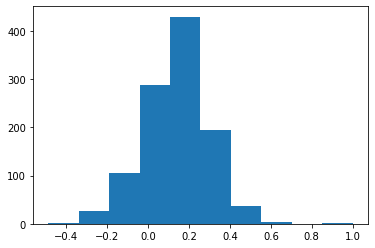

In [92]:
plt.hist(tra_F1)
plt.plot()